# Clean data and construct linear models to predict movie earnings

### Bring in the data

In [1]:
import pickle
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [2]:
# Read in the pickled list of dictionaries with movie data
with open('movies_data_raw.pickle','rb') as read_file:
    movies_raw = pickle.load(read_file)
    
# convert to a data frame
movies_df = pd.DataFrame(movies_raw)

### Remove unneeded columns and NA rows

In [3]:
# Drop title and international earnings, which won't be used in later analyses
movies_df.drop(columns=['Title','International'], inplace=True, axis=1)

In [4]:
# Change 'na' to np.nan
movies_df.replace('na',np.nan, inplace=True)

In [5]:
# Get a report of 'na' fields by feature
movies_df.apply(lambda x: sum(x.isna()), axis=0)

Studio         7
Opening      251
Budget      1386
Release        2
Rating       859
Runtime        0
Genre          0
Domestic       0
dtype: int64

In [6]:
# Budget and Opening account for most NAs. Drop these rows
movies_df.dropna(subset=['Budget','Opening'],axis=0,inplace=True)

### Impute ratings

In [7]:
# Movies are sorted by MPAA rating
# That let's us impute missing values in the rating column
for index, row in movies_df.iterrows():
    if row['Rating'] in ['G','PG','PG-13','R']:
        current_rating = row['Rating']
    else:
        row['Rating'] = current_rating

In [8]:
# Check if any NAs remaining
movies_df.apply(lambda x: sum(x.isna()), axis=0)

Studio      0
Opening     0
Budget      0
Release     0
Rating      0
Runtime     0
Genre       0
Domestic    0
dtype: int64

In [9]:
movies_df

,Studio,Opening,Budget,Release,Rating,Runtime,Genre,Domestic
0,Walt Disney Studios Motion Pictures,"$120,908,065","$200,000,000","June 20, 2019",G,1 hr 40 min,"[Adventure, Animation, Comedy, Family, Fantasy]","$434,038,008"
1,Walt Disney Studios Motion Pictures,"$1,586,753","$45,000,000","June 15, 1994",G,1 hr 28 min,"[Adventure, Animation, Drama, Family, Musical]","$422,783,777"
2,Walt Disney Studios Motion Pictures,"$110,307,189","$200,000,000","June 16, 2010",G,1 hr 43 min,"[Adventure, Animation, Comedy, Family, Fantasy]","$415,004,880"
3,Walt Disney Studios Motion Pictures,"$70,251,710","$94,000,000","May 30, 2003",G,1 hr 40 min,"[Adventure, Animation, Comedy, Family]","$380,843,261"
4,Walt Disney Studios Motion Pictures,"$62,577,067","$115,000,000","November 2, 2001",G,1 hr 32 min,"[Adventure, Animation, Comedy, Family, Fantasy]","$289,916,256"
...,...,...,...,...,...,...,...,...
3353,Lionsgate,"$14,118,444","$11,000,000","October 22, 2009",R,1 hr 30 min,"[Horror, Mystery]","$27,693,292"
3359,New Line Cinema,"$6,589,341","$3,500,000","April 28, 1995",R,1 hr 31 min,"[Comedy, Drama]","$27,467,564"
3360,Screen Gems,"$10,302,846","$6,000,000","March 23, 2001",R,1 hr 46 min,"[Comedy, Drama]","$27,457,409"
3361,A24,"$6,560,030","$9,000,000","July 3, 2019",R,2 hr 28 min,"[Drama, Horror, Mystery, Thriller]","$27,426,361"


### Convert Release Date to Year and Month DateTime objects

In [10]:
# Convert Release Date, drop the original
# Calculate year as # of years from earliest movie
movies_df['Year'] = pd.to_datetime(movies_df['Release']).dt.year - min(pd.to_datetime(movies_df['Release']).dt.year)
movies_df['Month'] = pd.to_datetime(movies_df['Release']).dt.month
movies_df.drop(columns=['Release'], inplace=True, axis=1)

# Replace numberical month with abbreviation
num_index = [_ for _ in range(1,13)]
month_index=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
movies_df['Month'] = movies_df['Month'].replace(num_index, month_index)

# Set dummy variables for month
month_dummies = pd.get_dummies(movies_df['Month'])
movies_df = pd.concat([movies_df, month_dummies], axis=1)
movies_df.drop(columns=['Month'], inplace=True, axis=1)

### Convert Runtime string to minutes integer

In [11]:
# Some runtimes list hours and minutes, some only list hours
# Use runtime_to_minutes to convert runtime string to an integer of total minutes
def runtime_to_minutes(row):
    """
    Split runtime string into hours and minutes (or just hours),
    convert values to integers, and return runtime as an integer of total minutes
    """
    time_list = row['Runtime'].split(' ')
    if len(time_list) == 2:
        tot_mins = int(time_list[0])*60
    else:
        tot_mins = int(time_list[0])*60 + int(time_list[2])
    return tot_mins

movies_df['Runtime'] = movies_df.apply(runtime_to_minutes, axis = 1)

# Bin movies by length
def bin_length(row):
    if row['Runtime'] <=80:
        return 'short'
    elif (row['Runtime'] >80) & (row['Runtime'] <=110):
        return 'medium'
    elif (row['Runtime'] >110) & (row['Runtime'] <=140):
        return 'long'
    else:
        return 'xlong'

movies_df['Length'] = movies_df.apply(bin_length, axis=1)

# Set dummies
runtime_dummies = pd.get_dummies(movies_df['Length'])
movies_df = pd.concat([movies_df, runtime_dummies], axis=1)
movies_df.drop(columns=['Length'], inplace=True, axis=1)

### Convert currency to integer values

In [12]:
# Convert currency strings to integers so they can be used as a continuous features
def currency_to_int(row):
    """
    Convert currency string in columns 'Opening', 'Budget', 'Domestic' and 'International' to integers.
    In cases where scraping algorithm set undefined international earnings equal to domestic, 
    replace international earnings with 0.
    """
    opening = int(row['Opening'].replace('$','').replace(',',''))
    budget = int(row['Budget'].replace('$','').replace(',',''))
    domestic = int(row['Domestic'].replace('$','').replace(',',''))
    return opening, budget, domestic

movies_df[['Opening','Budget','Domestic']] = list(movies_df.apply(currency_to_int, axis = 1))

### Create dummy variables for genre

In [13]:
genre_dummies = pd.get_dummies(movies_df['Genre'].apply(pd.Series).stack()).sum(level=0)
movies_df = pd.concat([movies_df, genre_dummies], axis=1)
movies_df.drop(columns=['Genre'], inplace=True, axis=1)

### Create dummy variables for rating

In [14]:
rating_dummies = pd.get_dummies(movies_df['Rating'])
movies_df = pd.concat([movies_df, rating_dummies], axis=1)
movies_df.drop(columns=['Rating'], inplace=True, axis=1)

### Reduce number of studios

In [15]:
# Get a list of studios that account for 90% of movies in the df
studio_counts = movies_df['Studio'].value_counts().reset_index()
top_studios = []
count = 0
i=0
while count < 0.9*len(movies_df):
    top_studios.append(studio_counts['index'].iloc[i])
    count+= studio_counts['Studio'].iloc[i]
    i+=1

# Replace studio name with "other" if not in the list of top_studios

def replace_studio(row):
    if row['Studio'] in top_studios:
        return row['Studio']
    else:
        return 'Other'

movies_df['Studio'] = movies_df.apply(replace_studio, axis=1)

In [16]:
movies_df['Studio'].value_counts()

Warner Bros.                           289
Universal Pictures                     259
Twentieth Century Fox                  234
Walt Disney Studios Motion Pictures    206
Paramount Pictures                     199
Sony Pictures Entertainment (SPE)      193
Other                                  178
Lionsgate                               79
New Line Cinema                         53
Screen Gems                             42
DreamWorks Distribution                 40
Metro-Goldwyn-Mayer (MGM)               33
Miramax                                 32
DreamWorks                              26
TriStar Pictures                        25
Focus Features                          24
Fox Searchlight Pictures                23
Name: Studio, dtype: int64

### Set dummy variables for studio

In [17]:
studio_dummies = pd.get_dummies(movies_df['Studio'])
movies_df = pd.concat([movies_df, studio_dummies], axis=1)
movies_df.drop(columns=['Studio'], inplace=True, axis=1)

## Explore correlations

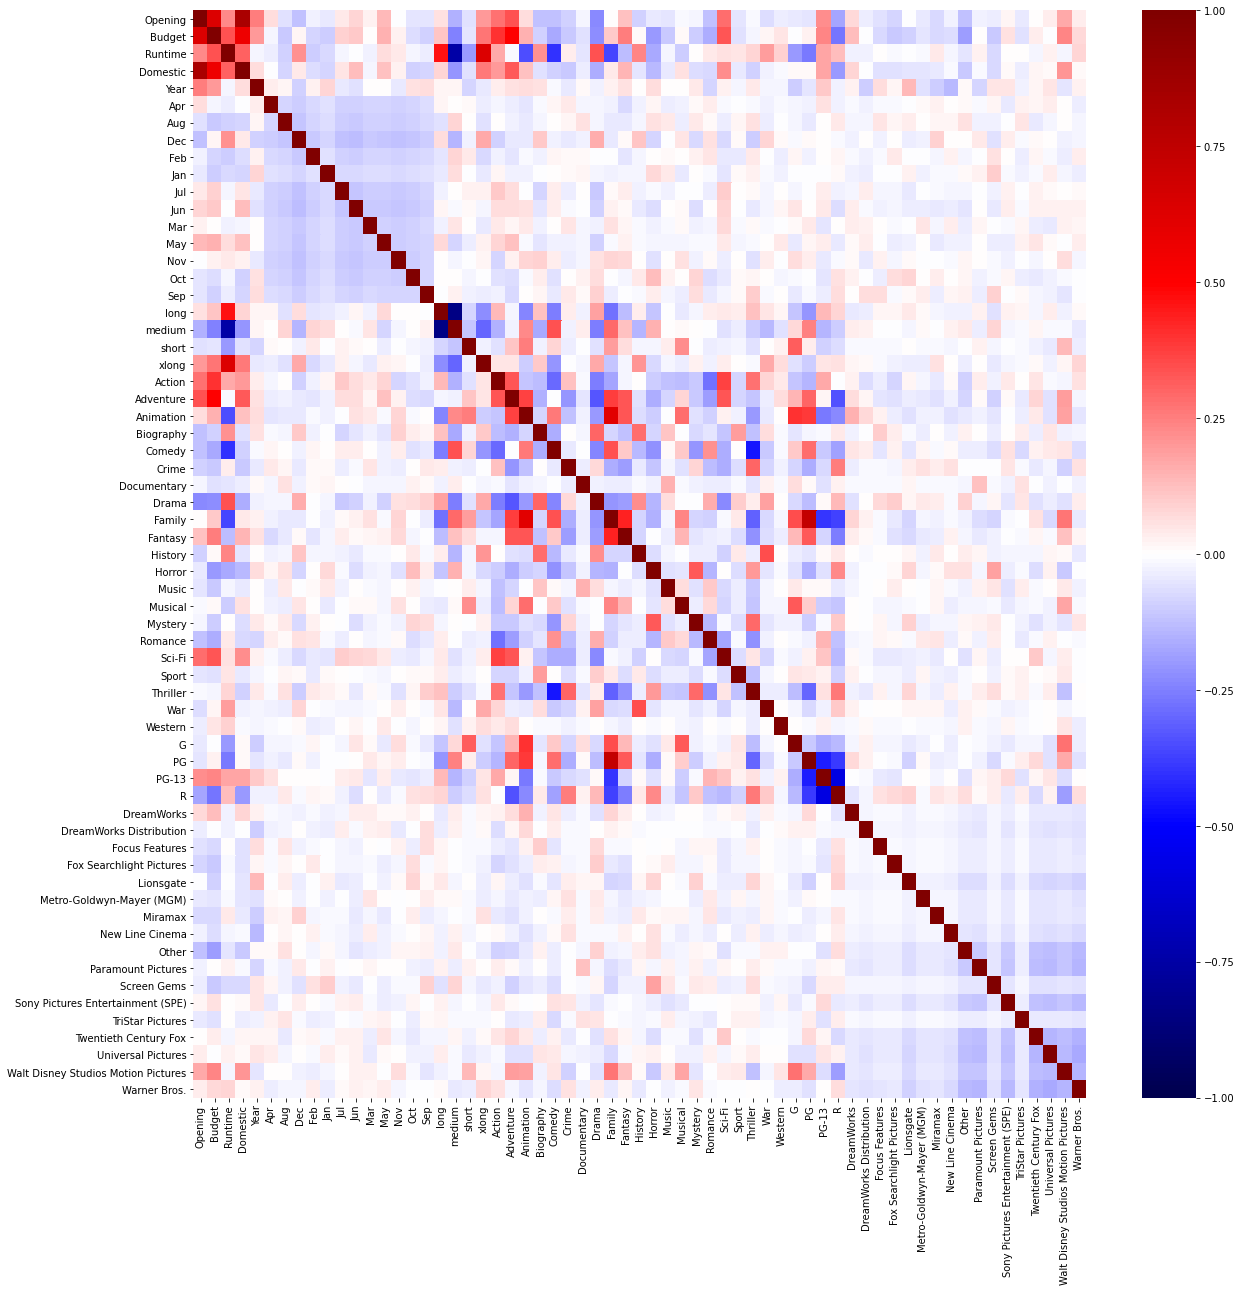

In [18]:
plt.figure(figsize=(20,20))
corrplot = sns.heatmap(movies_df.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);
figure = corrplot.get_figure()
figure.savefig("corrplot.png")

## Explore feature relationships

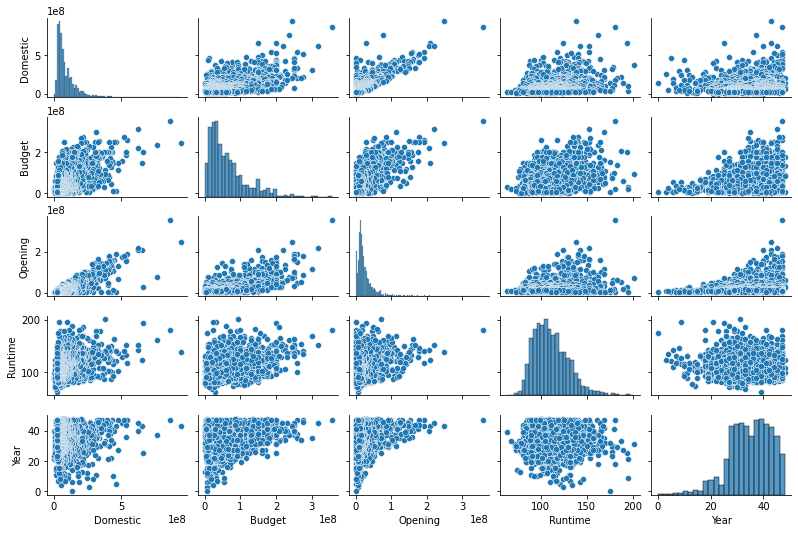

In [19]:
pairplot = sns.pairplot(movies_df[['Domestic','Budget','Opening','Runtime','Year']], height=1.5, aspect=1.5);
pairplot.savefig("pairplot.png")

## Create squared terms

In [20]:
movies_df['Budget_sq'] = movies_df['Budget']**2
movies_df['Opening_sq'] = movies_df['Opening']**2
movies_df['Year_sq'] = movies_df['Year']**2

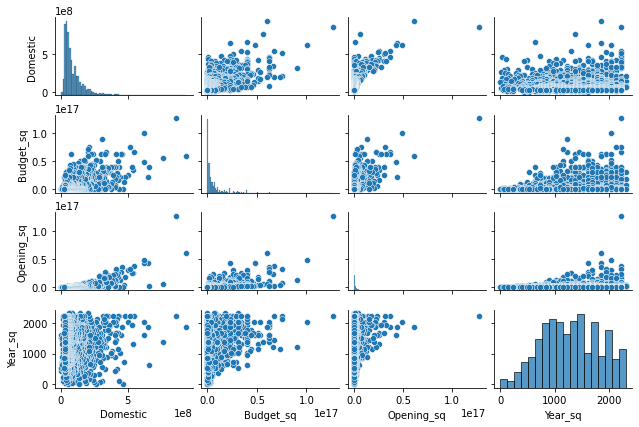

In [21]:
sns.pairplot(movies_df[['Domestic','Budget_sq','Opening_sq','Year_sq']], height=1.5, aspect=1.5);

### Define functions

In [22]:
# Define Train-Test-Split function:
def split_val(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    m = LinearRegression()
    m.fit(x_train,y_train)
    return m.score(x_train,y_train),(m.score(x_test,y_test))

In [23]:
def k_fold(x,y,n):
    """
    Use sklearn's KFold algorithm to divide data into n training and test sets.
    Report training and test R2 for each trial along with the mean and sd for all n trials.
    """
    x, y = np.array(x), np.array(y)
    kf = KFold(n_splits=n, shuffle=True, random_state = 71)
    cv_lm_r2s = [] #collect the validation results for both models
    cv_lm_r2s_train = []
    for train_ind, val_ind in kf.split(x,y):

        X_train, y_train = x[train_ind], y[train_ind]
        X_val, y_val = x[val_ind], y[val_ind] 

        lm = LinearRegression()

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
        cv_lm_r2s_train.append(lm.score(X_train, y_train))
        print(lm.score(X_train, y_train), lm.score(X_val, y_val))
    print('mean:', np.mean(cv_lm_r2s_train),np.mean(cv_lm_r2s))
    print('std:', np.std(cv_lm_r2s_train),np.std(cv_lm_r2s))


# Model: Domestic ~ features with >0.2 correlation with domestic earnings

In [24]:
movies_corr = movies_df.corr()
mask = ((movies_corr['Domestic'] >= 0.2) | (movies_corr['Domestic'] <= -0.2))
top_feat = movies_corr[mask]['Domestic'].reset_index()
features = list(top_feat['index'])
features.remove('Domestic')
X_20 = movies_df[features]
y = movies_df['Domestic']
print(len(features))
features

11


['Opening',
 'Budget',
 'Runtime',
 'medium',
 'xlong',
 'Action',
 'Adventure',
 'Sci-Fi',
 'Walt Disney Studios Motion Pictures',
 'Budget_sq',
 'Opening_sq']

### Linear model with squared terms

In [25]:
k_fold(X_20,y,5)

0.7270768867026257 0.6066097134244244
0.7088282459905966 0.6837954936914716
0.7041892074826971 0.6911372527603774
0.704678048652734 0.7030073216095585
0.6830237310091307 0.7604336444275291
mean: 0.7055592239675569 0.6889966851826722
std: 0.014029954900503454 0.049231665860937364


### Linear model with squared and interaction terms

In [26]:
p = PolynomialFeatures(interaction_only=True)
X_20_poly = p.fit_transform(X_20)
k_fold(X_20_poly,y,5)

0.642843165332992 0.47586766522152735
0.6182240803414186 0.5461542498500309
0.6336350020396098 0.1514718900125771
0.6239172472840333 0.558977714902793
0.5819997499727335 0.6830354572017245
mean: 0.6201238489941574 0.48310139543773056
std: 0.02083345631063924 0.1787383356081869


### Linear model without squared terms

In [27]:
X_20 = movies_df[features].drop(columns=['Opening_sq','Budget_sq'],axis=1)
y = movies_df['Domestic']

In [28]:
k_fold(X_20,y,5)

0.7364346401610029 0.622063917495902
0.7177682984930083 0.7034625513316162
0.7126532137618198 0.7261824443580058
0.7172026085553548 0.7012145433618204
0.6958140256959665 0.7661493602880671
mean: 0.7159745573334305 0.7038145633670825
std: 0.012967798313424084 0.04706591361922245


### Linear model without squared terms, with interaction terms

In [29]:
p = PolynomialFeatures(interaction_only=True)
X_20_poly = p.fit_transform(X_20)
k_fold(X_20_poly,y,5)

0.7300812245964854 0.5990931441306319
0.7294674745602285 0.6857067859131434
0.7279815126890933 0.7124862931362208
0.7127415965871093 0.6687624795598512
0.700403747660229 0.7545077499213434
mean: 0.7201351112186292 0.6841112905322382
std: 0.011760739427270392 0.05143348926261854


# Model: Domestic ~ All

In [30]:
X_all = movies_df.drop(columns=['Domestic'], axis=1)
y = movies_df['Domestic']

### Linear model with squared terms

In [31]:
k_fold(X_all,y,5)

0.7413024098592284 0.627575129678644
0.7236136391487082 0.7028907015793722
0.7211081346216791 0.7033630471120136
0.7216029525890408 0.7101933800059601
0.6971633926481952 0.7781747408365591
mean: 0.7209581057733703 0.7044393998425098
std: 0.01405396225287219 0.04771096693332582


### Linear model with squared and interaction terms

In [32]:
p = PolynomialFeatures(interaction_only=True)
X_all_poly = p.fit_transform(X_all)
k_fold(X_all_poly,y,5)

0.6573112294543724 0.5086874845063138
0.6379555179233247 0.5938817985658946
0.6410205210640302 0.34178903154475604
0.6411389431639827 0.5700738972607899
0.6067241477196594 0.6875665127385271
mean: 0.6368300718650739 0.5403997449232564
std: 0.016512040152790043 0.11476134005617726


### Linear model without squared terms

In [33]:
X_all_nosq = movies_df.drop(columns=['Domestic','Opening_sq','Budget_sq','Year_sq'], axis=1)
y = movies_df['Domestic']

In [34]:
k_fold(X_all_nosq,y,5)

0.7911691207538789 0.6700181125460472
0.775806698845946 0.7403255477622658
0.7707164630481769 0.7685916123806062
0.7740276935957705 0.7435005177986639
0.7521797107119876 0.8115540273466654
mean: 0.7727799373911519 0.7467979635668498
std: 0.012470024144286605 0.04607867568103731


### Linear model without squared terms, with interaction terms

In [35]:
p = PolynomialFeatures(interaction_only=True)
X_all_poly_nosq = p.fit_transform(X_all_nosq)
k_fold(X_all_poly_nosq,y,5)

0.844540506168071 0.6263406124064024
0.7883571306534785 0.4392660382513288
-0.3746065383915782 0.1338409458277311
0.6775388981937556 0.430537520792033
0.7569983275795961 0.7321256827956966
mean: 0.5385656648406646 0.4724221600146383
std: 0.459766514747237 0.20426830382858666


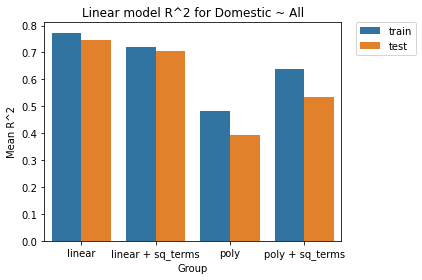

In [36]:
all_bar_df = pd.DataFrame({'Group':['linear','linear','linear + sq_terms','linear + sq_terms','poly','poly','poly + sq_terms','poly + sq_terms'],\
 'Mean R^2':[0.773, 0.747, 0.721, 0.704, 0.483, 0.393, 0.638, 0.536],\
 'Set':['train','test','train','test','train','test','train','test']})
plt.figure(figsize=(6, 4))
all_bar_linear = sns.barplot(x='Group', y='Mean R^2', hue = 'Set', data=all_bar_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Linear model R^2 for Domestic ~ All');
plt.tight_layout()
figure = all_bar_linear.get_figure()
figure.savefig("All_Bar.png")

### Residuals plot - linear model without squared terms

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X_all_nosq, y, test_size=0.2)
m = LinearRegression()
m.fit(x_train,y_train)
lin_residuals = y_test-m.predict(x_test)

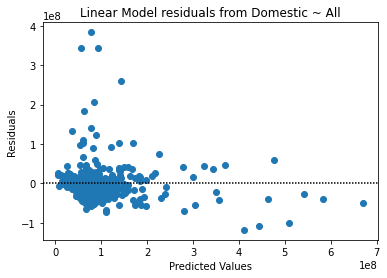

In [38]:
#Plot residuals from linear model
plt.figure(figsize=(6, 4))
All_residuals = plt.scatter(m.predict(x_test), lin_residuals)
plt.axhline(0, linestyle=(0,(1,1)), color='black')
plt.title('Linear Model residuals from Domestic ~ All')
plt.xlabel('Predicted Values', fontsize=10)
plt.ylabel('Residuals', fontsize=10);
figure = All_residuals.get_figure()
figure.savefig("All_residuals.png")

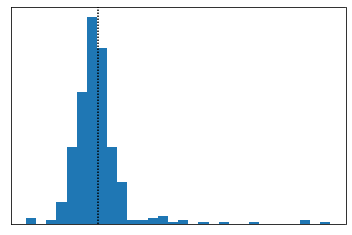

In [39]:
plt.hist(lin_residuals,bins=30);
plt.yticks([])
plt.xticks([])
plt.axvline(0, linestyle=(0,(1,1)), color='black')
plt.savefig('residuals_histogram.png')

### Look at model metrics with statsmodel

In [40]:
model = sm.OLS(y_train, x_train)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Domestic   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     93.14
Date:                Sat, 10 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:22:49   Log-Likelihood:                -29345.
No. Observations:                1548   AIC:                         5.881e+04
Df Residuals:                    1489   BIC:                         5.912e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Opening                                 2.8164      0.055     51.006      0.000       2.708       2.925
Budget                                 -0.0825      0.037     -2.255      0.024      -0.154      -0.011
Runtime                              7.219e+05   1.48e+05      4.878      0.000    4.32e+05    1.01e+06
Year                                -1.278e+06   1.57e+05     -8.123      0.000   -1.59e+06    -9.7e+05
Apr                                 -1.711e+07   4.57e+06     -3.745      0.000   -2.61e+07   -8.15e+06
Aug                                 -9.301e+05   4.45e+06     -0.209      0.834   -9.65e+06    7.79e+06
Dec                                  2.749e+07   4.12e+06      6.671      0.000    1.94e+07    3.56e+07
Feb                                 -8.866e+06   4.45e+06     -1.995      0.046   -1.76e+07   -1.46e+05
Jan                                 -6.937e+06   5.24e+06     -1.324      0.186   -1.72e+07    3.34e+06
Jul                                  5.132e+06   3.95e+06      1.298      0.195   -2.62e+06    1.29e+07
Jun                                  1.282e+07   4.01e+06      3.194      0.001    4.95e+06    2.07e+07
Mar                                 -1.294e+07   4.56e+06     -2.840      0.005   -2.19e+07      -4e+06
May                                  7.847e+05   4.39e+06      0.179      0.858   -7.83e+06     9.4e+06
Nov                                  1.225e+06   4.31e+06      0.284      0.776   -7.23e+06    9.68e+06
Oct                                 -7.289e+06   4.24e+06     -1.718      0.086   -1.56e+07    1.03e+06
Sep                                 -5.404e+06   4.78e+06     -1.130      0.259   -1.48e+07    3.98e+06
long                                -9.351e+05   8.34e+06     -0.112      0.911   -1.73e+07    1.54e+07
medium                               5.564e+06   5.76e+06      0.967      0.334   -5.73e+06    1.69e+07
short                               -1.639e+07    9.7e+06     -1.689      0.091   -3.54e+07    2.65e+06
xlong                               -2.665e+05   1.26e+07     -0.021      0.983    -2.5e+07    2.45e+07
Action                              -3.769e+06   3.15e+06     -1.197      0.231   -9.94e+06    2.41e+06
Adventure                            1.094e+06   3.24e+06      0.337      0.736   -5.26e+06    7.45e+06
Animation                            2.387e+07   5.12e+06      4.661      0.000    1.38e+07    3.39e+07
Biography                            1.076e+07   5.66e+06      1.902      0.057   -3.39e+05    2.19e+07
Comedy                               1.702e+06   3.17e+06      0.536      0.592   -4.52e+06    7.93e+06
Crime                               -2.294e+06   3.54e+06     -0.649      0.517   -9.23e+06    4.64e+06
Documentary                         -2.047e+07   1.51e+07     -1.35

# LassoCV regularization on linear model

In [41]:
m = LassoCV()
scaler = StandardScaler(with_mean=False)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
m.fit(x_train_scaled,y_train)
print(m.score(x_train_scaled,y_train))
print(m.score(x_test_scaled,y_test))

0.7788983148928329
0.7149287753446261


In [42]:
# get a list of features that didn't shrink to zero
lasso_features =[]
for i in range(len(m.coef_)):
    if abs(m.coef_[i]) > 1:
        lasso_features.append(x_train.columns[i])

### Use lasso-reduced features to build a linear model

In [43]:
X_lasso_reduced = movies_df[lasso_features]
k_fold(X_lasso_reduced,y,5)

0.785051097248799 0.6920667972487515
0.7730776064814209 0.7413938929031227
0.7681043690764909 0.7678925630690814
0.7705903246239707 0.7505380740535198
0.7502426144373078 0.81197009041226
mean: 0.7694132023735978 0.752772283537347
std: 0.011212329970244725 0.03886545695831906


### Residulals plot - lasso-reduced model

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X_lasso_reduced, y, test_size=0.2)
m_red = LinearRegression()
m_red.fit(x_train,y_train)
lasso_residuals = y_test - m_red.predict(x_test)

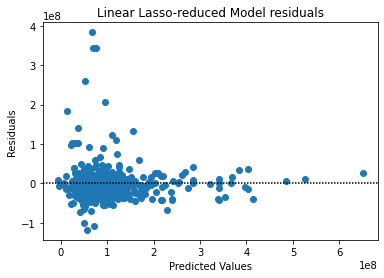

In [45]:
#Plot residuals from linear model
plt.figure(figsize=(6, 4))
lasso_red_residuals = plt.scatter(m_red.predict(x_test), lin_residuals)
plt.axhline(0, linestyle=(0,(1,1)), color='black')
plt.title('Linear Lasso-reduced Model residuals')
plt.xlabel('Predicted Values', fontsize=10)
plt.ylabel('Residuals', fontsize=10);
figure = lasso_red_residuals.get_figure()
figure.savefig("lasso_red_residuals.png")

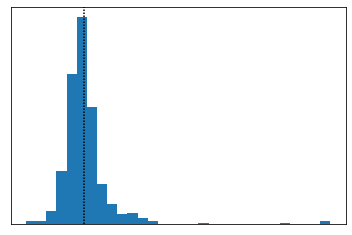

In [46]:
plt.hist(lasso_residuals,bins=30);
plt.yticks([])
plt.xticks([])
plt.axvline(0, linestyle=(0,(1,1)), color='black')
plt.savefig('lasso_residuals_histogram.png')

### Lasso CV - polynomial

In [47]:
"""mp = LassoCV()

p = PolynomialFeatures(degree=2)
X_train_poly = p.fit_transform(x_train)
X_test_poly = p.fit_transform(x_test)

scaler = StandardScaler(with_mean=False)
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.fit_transform(X_test_poly)

mp.fit(X_train_poly_scaled,y_train)

print(mp.score(X_train_poly_scaled,y_train))
print(mp.score(X_test_poly_scaled,y_test))
"""

'mp = LassoCV()\n\np = PolynomialFeatures(degree=2)\nX_train_poly = p.fit_transform(x_train)\nX_test_poly = p.fit_transform(x_test)\n\nscaler = StandardScaler(with_mean=False)\nX_train_poly_scaled = scaler.fit_transform(X_train_poly)\nX_test_poly_scaled = scaler.fit_transform(X_test_poly)\n\nmp.fit(X_train_poly_scaled,y_train)\n\nprint(mp.score(X_train_poly_scaled,y_train))\nprint(mp.score(X_test_poly_scaled,y_test))\n'

In [48]:
"""# get a list of features that didn't shrink to zero
lasso_poly_features =[]
for i in range(len(mp.coef_)):
    if abs(mp.coef_[i]) > 1:
        lasso_poly_features.append(p.get_feature_names()[i])"""

"# get a list of features that didn't shrink to zero\nlasso_poly_features =[]\nfor i in range(len(mp.coef_)):\n    if abs(mp.coef_[i]) > 1:\n        lasso_poly_features.append(p.get_feature_names()[i])"